In [1]:
from commons import *
metafeatures = ["numattributes", "numlabels", "numnumericattributes", "numsymbolicattributes", "numberofcategories", "numericattributesafterbinarization", "attributestocover50pctvariance", "attributestocover90pctvariance", "attributestocover95pctvariance", "attributestocover99pctvariance"]
inputfeaturesDataset = [x + "_before" for x in metafeatures]
targets = [x + "_after" for x in metafeatures]

fileResultsSample = "data/workdata/metafeaturepredictionresults-selection.csv"
fileResultsFinal = "data/workdata/metafeaturepredictionresults-final.csv"

def getFeatureShortcut(a):
    return featureAliases[a.replace("_before", "")] if a.replace("_before", "") in featureAliases else a

In [3]:
df = pd.read_csv("data/metafeaturetransformations.csv", delimiter=";")
print(all(df["numinstances_before"] == df["numinstances_after"]))
dfSample = df[df["openmlid"].isin(coredatasets)]
dfSample

True


,openmlid,algorithm,algorithmoptions,numinstances_before,numattributes_before,numberofcategories_before,numericattributesafterbinarization_before,numlabels_before,numnumericattributes_before,numsymbolicattributes_before,...,numberofcategories_after,numericattributesafterbinarization_after,numlabels_after,numnumericattributes_after,numsymbolicattributes_after,attributestocover50pctvariance_after,attributestocover90pctvariance_after,attributestocover95pctvariance_after,attributestocover99pctvariance_after,totalvariance_after
0,3,bestfirst_cfssubseteval,-D 2 -N 1000 -S 0;-L,100,5,10,5,2,0,5,...,2,1,2,0,1,1,1,1,1,0.114242
1,57,bestfirst_cfssubseteval,-D 1 -N 1 -S 2;-L -M,100,5,0,5,3,5,0,...,0,1,3,1,0,1,1,1,1,278.304314
2,741,bestfirst_cfssubseteval,-D 1 -N 1 -S 2;-L,100,5,4,8,2,4,1,...,4,5,2,1,1,1,1,1,1,132.352121
3,743,bestfirst_cfssubseteval,-D 2 -N 1 -S 0;-M -Z,100,5,0,5,2,5,0,...,0,1,2,1,0,1,1,1,1,1.027018
4,772,bestfirst_cfssubseteval,-D 0 -N 100 -S 1;-M -Z,100,5,0,5,2,5,0,...,0,1,2,1,0,1,1,1,1,12480.485253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275002,813,ranker_symmetricaluncertattributeeval,-N 6;-M,1000000,250,0,250,2,250,0,...,0,6,2,6,0,3,5,5,6,4.958846
275003,903,ranker_symmetricaluncertattributeeval,-N 100;,1000000,250,0,250,2,250,0,...,0,100,2,100,0,17,69,85,97,25.919411
275004,904,ranker_symmetricaluncertattributeeval,-N 50;,1000000,250,0,250,2,250,0,...,0,50,2,50,0,25,45,48,50,37.041848
275005,914,ranker_symmetricaluncertattributeeval,-N 1;-M,1000000,250,0,250,2,250,0,...,0,1,2,1,0,1,1,1,1,0.026559


## 1. For each pre-processor, which Subsets of size at most 3 can best predict the number of attributes?

### Compute the error of a linear regression of each feature set, each pre-processor, and each sample ds

In [7]:
def getAllFeatureSetsOfSizeK(features, minK, maxK):
    F = []
    for k in range(minK,maxK + 1):
        F.extend([list(x) for x in itertools.combinations(features, k)])
    return F

def gatherPredictionResults(df, featurecombos, fileResults, syntheticFeature = False):
    cols = ["featureset", "algorithm", "openmlid", "RMSE"]
    dfResults = pd.DataFrame([], cols)

    pbar = tqdm(total = len(preprocessors) * len(coredatasets) * len(featurecombos))
    dfResults = pd.read_csv(fileResults, delimiter=";") if path.exists(fileResults) else pd.DataFrame([], columns=cols)
    i = 0
    for a in preprocessors:
        dfAlgo = df[df["algorithm"] == a]
        if len(dfAlgo) > 0:
            dfAlgo = explodeAlgorithmOptions(dfAlgo)
            dfCacheMatch1 = dfResults[dfResults["algorithm"] == a]
            
            # observe predictability for all possible feature combos
            for features in featurecombos:
                target = "numattributes_after"
                algoParams = [x for x in dfAlgo.columns if not x in df.columns]
                algoParams.remove("searcheroptions")
                algoParams.remove("evaloptions")
                algoSpecificFeatures = features.copy()
                metafeatures = features.copy()
                algoSpecificFeatures.extend(algoParams)
                if syntheticFeature:
                    metafeatures.append("minAttN")
                    if ("ranker" in a or "greedy" in a):
                        dfAlgo["minAttN"] = np.minimum(dfAlgo["numattributes_before"], dfAlgo["N"])
                        algoSpecificFeatures.append("minAttN")
                    

                dfCacheMatch2 = dfCacheMatch1[(dfCacheMatch1["featureset"] == str(metafeatures))]
                for d in coredatasets:
                    match = dfCacheMatch2[dfCacheMatch2["openmlid"] == d]
                    if len(match) == 0:
                        trainIndices = dfAlgo["openmlid"] != d
                        trainDF = dfAlgo[trainIndices]
                        validationDF = dfAlgo[~trainIndices]
                        if len(validationDF) > 0:
                            
                            # build regression model
                            reg = sk.linear_model.LinearRegression()
                            reg.fit(trainDF[algoSpecificFeatures], trainDF[target])
                            actuals = validationDF[target].values
                            predictions = np.maximum(1, np.round(reg.predict(validationDF[algoSpecificFeatures])))
                            if len(predictions) != len(actuals):
                                raise Exception()
                            
                            # register result line
                            rmse = RMSE(actuals, predictions)
                            dfResults.loc[len(dfResults)] = [str(metafeatures), a, d, rmse]
                            
                            # serialize model for predicting
                            filename = 'data/models/linear/transform_' + a + '_' + str(d) + '_' + str([getFeatureShortcut(a) for a in metafeatures]) + '.mod'
                            if syntheticFeature:
                                print("Writing model for metafeatures " + str(metafeatures) +" to " + filename)
                            pickle.dump(reg, open(filename, 'wb'))
                            
                            i += 1
                            if i % 500 == 0:
                                print("Writing intermediate results to", fileResults)
                                dfResults.to_csv(fileResults, index=False, sep=";")
                                i = 0
                        else:
                            warning("No observations for algorithm " + a + " on openmlid " + str(d) + " for features " + str(features))
                    pbar.update(1)
        else:
            warning("No observations for algorithm " + a)
            pbar.update(len(featurecombos) * len(coredatasets))

    if i > 0:
        print("Writing results to", fileResults)
        dfResults.to_csv(fileResults, index=False, sep=";")
    else:
        print("NOT writing results to", fileResults)
    pbar.close()

In [ ]:
combos = getAllFeatureSetsOfSizeK(inputfeaturesDataset, 1, 3)
combos.append(inputfeaturesDataset) # also consider the complete set
gatherPredictionResults(dfSample, combos, fileResultsSample, syntheticFeature=False)
gatherPredictionResults(dfSample, [["numattributes_before"]], fileResultsSample, syntheticFeature=True)

Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate results to data/workdata/metafeaturepredictionresults-selection.csv
Writing intermediate 

### Create a box plot series of the 20 best sets with one box plot per feature set over the observed rmses

In [103]:
dfResultsSample = pd.read_csv(fileResultsSample, delimiter=";")

Best feature set: ['numattributes_before', 'minAttN']
Performance of this set: 4.407877550132019
Performance of simple set: 4.407877550132019


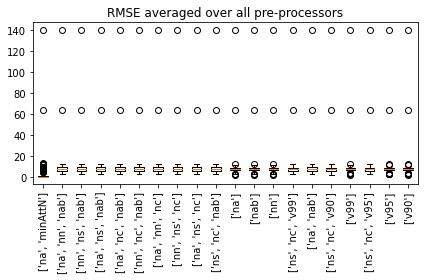

In [104]:
fsets = []
groups = []
scores = []
for gIndex, group in dfResultsSample.groupby("featureset"):
    rmse = np.mean(group["RMSE"])
    groups.append(group["RMSE"].values)
    fsets.append(gIndex)
    scores.append(rmse)
indices = np.argsort(scores)[0:20]

print("Best feature set: " + str(ast.literal_eval(fsets[indices[0]])))
print("Performance of this set: " + str(scores[indices[0]]))
print("Performance of simple set: " + str(scores[fsets.index("['numattributes_before', 'minAttN']")]))

fig = plt.figure()
plt.boxplot([groups[i] for i in indices])
ax = fig.axes[0]
ax.set_title("RMSE averaged over all pre-processors")
ax.set_xticklabels([str([getFeatureShortcut(a) for a in ast.literal_eval(fsets[i])]) for i in indices], rotation=90)
plt.tight_layout()
plt.savefig("plots/metafeatures-featuresets.pdf")
plt.show()

### Create also one series per algorithm to see whether there are local differences

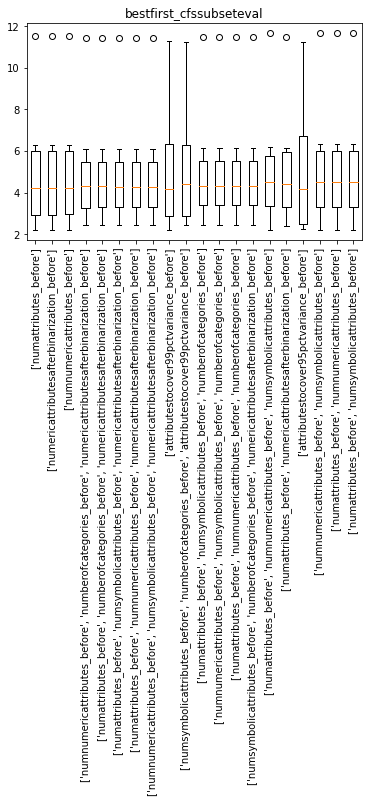

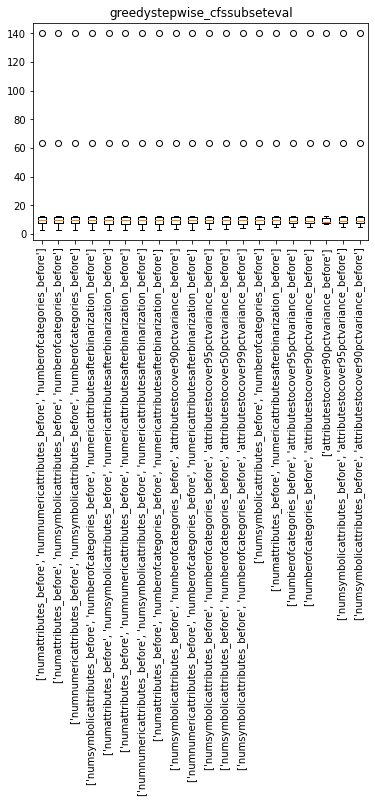

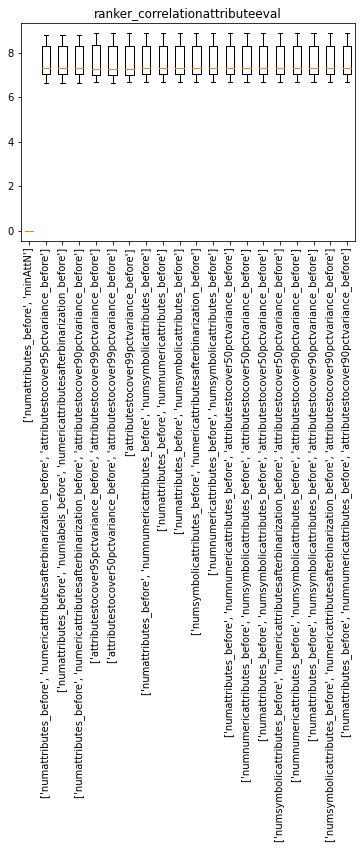

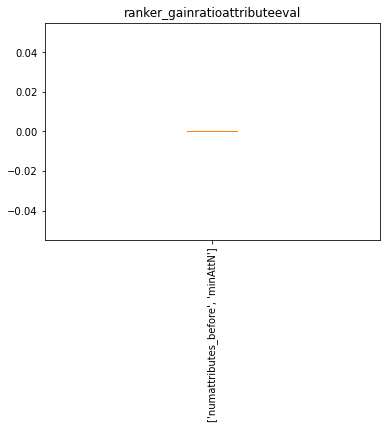

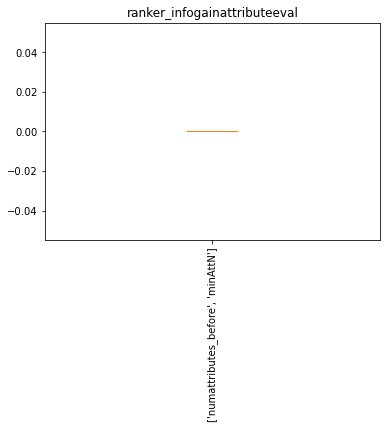

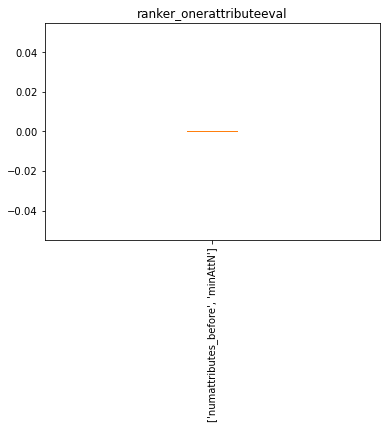

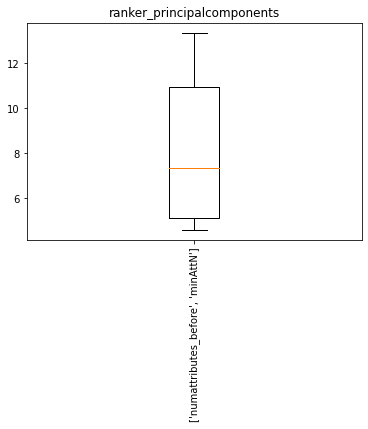

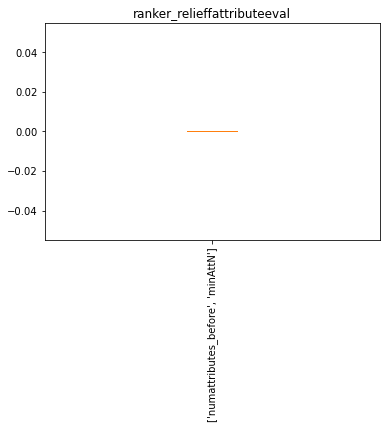

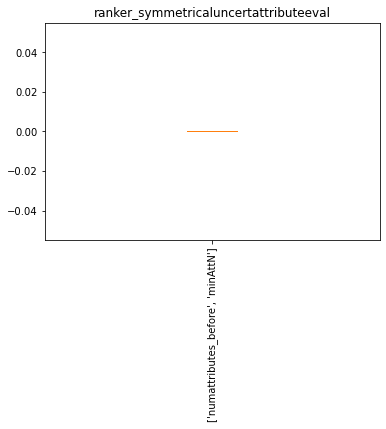

In [105]:
for algo in preprocessors:
    fsets = []
    groups = []
    scores = []
    for gIndex, group in dfResultsSample.query("algorithm == '" + algo + "'").groupby("featureset"):
        rmse = np.mean(group["RMSE"])
        groups.append(group["RMSE"].values)
        fsets.append(gIndex)
        scores.append(rmse)
    indices = np.argsort(scores)[0:20]

    fig = plt.figure()
    plt.boxplot([groups[i] for i in indices])
    ax = fig.axes[0]
    ax.set_title(algo)
    ax.set_xticklabels([str(fsets[i]) for i in indices], rotation=90)
    plt.show()
    

**Observation**: Indeed, greedystepwise seems to be sensitive to the feature set.

# 2. What is the RMSE/relative error per learner overall for this FS?

## Gather results for this question

In [106]:
combosFinal = [['numattributes_before'], ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before']]
gatherPredictionResults(df, [combosFinal[0]], fileResultsFinal, syntheticFeature=True)
gatherPredictionResults(df, [combosFinal[1]], fileResultsFinal, syntheticFeature=True)
combosFinal[0].append("minAttN")
combosFinal[1].append("minAttN")

Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_3_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_57_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_741_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_743_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_772_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_813_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_bestfirst_

Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_ranker_principalcomponents_3_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_ranker_principalcomponents_57_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_ranker_principalcomponents_741_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_ranker_principalcomponents_743_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_ranker_principalcomponents_772_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/transform_ranker_principalcomponents_813_['na', 'minAttN'].mod
Writing model for metafeatures ['numattributes_before', 'minAttN'] to data/models/linear/tr

Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_3_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_57_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_741_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_bestfirst_cfssubseteval_743_['nc', 'v90', 'v99', 'minAttN'].mod
Wri

Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_ranker_infogainattributeeval_3_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_ranker_infogainattributeeval_57_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_ranker_infogainattributeeval_741_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_ranker_infogainattributeeval_743_['nc', 'v90', 'v99'

Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_ranker_symmetricaluncertattributeeval_3_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_ranker_symmetricaluncertattributeeval_57_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_ranker_symmetricaluncertattributeeval_741_['nc', 'v90', 'v99', 'minAttN'].mod
Writing model for metafeatures ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'minAttN'] to data/models/linear/transform_ranker_symmetricaluncerta

In [107]:
combosFinal

[['numattributes_before', 'minAttN'],
 ['numberofcategories_before',
  'attributestocover90pctvariance_before',
  'attributestocover99pctvariance_before',
  'minAttN']]

### Plot lof-RMSE for each learner using for the best case and for numattributes_before over all datasets

In [108]:
dfResultsFinal = pd.read_csv(fileResultsFinal, delimiter=";")
dfResultsFinal.query("featureset == \"" + str(combosFinal[0]) + "\" and algorithm == 'ranker_principalcomponents'")

,featureset,algorithm,openmlid,RMSE
60,"['numattributes_before', 'minAttN']",ranker_principalcomponents,3,6.047977
61,"['numattributes_before', 'minAttN']",ranker_principalcomponents,57,9.354077
62,"['numattributes_before', 'minAttN']",ranker_principalcomponents,741,9.214167
63,"['numattributes_before', 'minAttN']",ranker_principalcomponents,743,5.773033
64,"['numattributes_before', 'minAttN']",ranker_principalcomponents,772,11.576850
65,"['numattributes_before', 'minAttN']",ranker_principalcomponents,813,5.332874
66,"['numattributes_before', 'minAttN']",ranker_principalcomponents,903,5.598364
67,"['numattributes_before', 'minAttN']",ranker_principalcomponents,904,5.824410
68,"['numattributes_before', 'minAttN']",ranker_principalcomponents,914,12.670949
69,"['numattributes_before', 'minAttN']",ranker_principalcomponents,923,11.091494


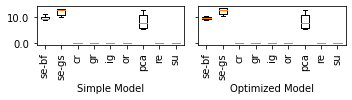

In [111]:
xlabels = [algorithmshortcuts[a] for a in preprocessors]
ylabels = np.linspace(0, 40, 5)
fig, ax = plt.subplots(1, 2, figsize=(5, 1.5), sharey = True)
a = ax[0]
a.boxplot([dfResultsFinal.query("featureset == \"" + str(combosFinal[0]) + "\" and algorithm == '" + a + "'")["RMSE"].values for a in preprocessors], 0, '')
a.set_xticklabels(xlabels, rotation=90)
a.set_yticks(np.array(ylabels))
a.set_yticklabels(ylabels)
a.set_xlabel("Simple Model")
a = ax[1]
a.boxplot([dfResultsFinal.query("featureset == \"" + str(combosFinal[1]) + "\" and algorithm == '" + a + "'")["RMSE"].values for a in preprocessors], 0, '')
a.set_xticklabels(xlabels, rotation=90)
a.set_xlabel("Optimized Model")
fig.tight_layout()
fig.savefig("plots/metafeaturepredictability.pdf")
plt.show()

### Create one file per pre-processor

In [143]:
cols = list(df.columns)
for algo in tqdm(preprocessors):
    dfAlgo = df[df["algorithm"] == algo]
    if len(dfAlgo) > 0:
        dfAlgo = explodeAlgorithmOptions(dfAlgo)
        algoSpecificCols = [x for x in dfAlgo.columns if not x in cols]
        algoSpecificCols.remove("searcheroptions")
        algoSpecificCols.remove("evaloptions")
        colsHere = ["openmlid", "algorithm", "numattributes_before"]
        colsHere.extend(algoSpecificCols)
        if "ranker" in algo or "greedy" in algo:
            dfAlgo["minAttN"] = np.minimum(dfAlgo["numattributes_before"], dfAlgo["N"])
            colsHere.append("minAttN")
        colsHere.append("numattributes_after")
        target_file = "data/metamodeldata/" + algo + ".csv"
        dfAlgo[colsHere].to_csv(target_file, index=False)
        print("Saved runtime file for " + algo + " to " + target_file)
    else:
        warning("No data for " + algo + ", not creating a file.")

Saved runtime file for ranker_principalcomponents to data/metamodeldata/ranker_principalcomponents.csv

